# Deep Learning for Geo/Environmental sciences

<center><img src="../logo_2.png" alt="logo" width="600"/></center>

<em>*Created with ChapGPT</em>

## Lecture 4: Non-linear regression

 - [Introduction](#Introduction)
- [Decision Trees](#Decision-Trees)
 - [Random Forest](#Random-Forest)
 - [Gaussian Processes](#Gaussian-Processes)

In this lesson, we introduce some core regression techniques, including random forests and Gaussian processes. These are not really 'Deep Learning' but I wanted to include them because they are powerful and expressive regression models with some nice properties.

By the end of the lesson, we will be able to:
- Understand the objectives and components of regression.
- Understand the basic concepts of decision trees.
- Perform regression using decision trees and random forests
- Understand the basic concepts of Gaussian processes.

## Introduction

The purpose of regression is to predict a continuous value based on observation data, i.e., stock price, temperature, and (even) GPA of a class.

In this lesson, we will introduce two non-linear regression techniques: decision trees and Gaussian processes. Decision trees are a simple and interpretable model that can be used for regression. Gaussian processes are a more complex model that can capture complex patterns in the data.

Let's do a very quick refresh of linear regression though, to introduce the workflow. It models the relationship between the input variables and the output variable as a linear function. The goal of linear regression is to find the best-fitting line that minimizes the sum of the squared differences between the observed values and the predicted values.

### A simple example - linear regression

In the `scikit-learn` library, `LinearRegression` fits a _linear model_ $$\hat{f}(w, x) = w_1 x_1 + ... + w_p x_p + b$$ with coefficients $w = (w_1, ..., w_p)$ and bias $b$ to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation. Mathematically it solves a problem of the form:$$\min_{w} L(X,f(X)),$$ where $L(X,f(X))=|| X w - f(X)||_2^2$ is the loss function. Note that $X=(x_1, ..., x_p)$ is a vector while $f(X)$ is a number.

Let's look at its application. **First**, we import the libraries needed and load some sample data.

In [1]:
# Code source: Jaques Grobler
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Load the diabetes dataset
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True, as_frame=True)

diabetes_X

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930


In [2]:
# Use only one feature
diabetes_X = diabetes_X[['bmi']]

# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes_y[:-20]
diabetes_y_test = diabetes_y[-20:]

**Then**, we build the model `regr` and train it. For linear regression, we try to minimize the mean square error as defined above. Note that because the optimal coefficients $w$ can be derived analytically. We do not need an optimization algorithm in this case. (Unfortunately, in most cases this is impossible, and 99% of the time we still need an optimization algorithm)

In [3]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(diabetes_y_test, diabetes_y_pred))

Coefficients: 
 [938.23786125]
Mean squared error: 2548.07
Coefficient of determination: 0.47


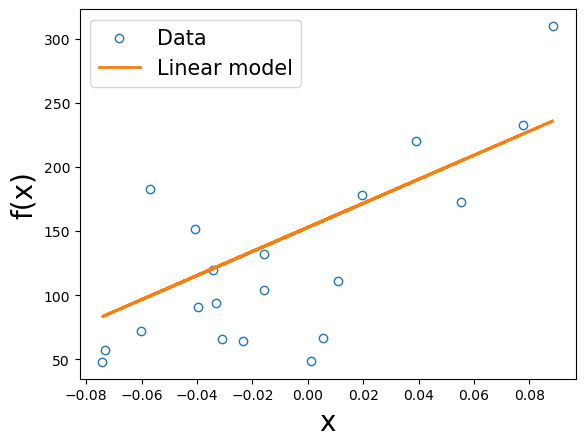

In [4]:
# Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test,label="Data",edgecolor="C0",facecolor="w")
plt.plot(diabetes_X_test, diabetes_y_pred,linewidth=2,label="Linear model",color="C1")
plt.xlabel("x", fontsize=20)
plt.ylabel("f(x)", fontsize=20)
plt.legend(fontsize = 15)
plt.show()

## Decision trees 

### Introduction 

These very simple models are based on a tree structure. The idea is to split the data into subsets based on the value of a feature. The split is done in such a way that the variance of the target variable is minimized. This process is repeated recursively until a stopping criterion is met.

They are very easy to interpret and can be used for both regression and classification. However, they tend to overfit the data and are not very robust.

Let's see an example of a decision tree in action. We will use the `DecisionTreeRegressor` class from the `sklearn.tree` module.

### Example of decision tree regression
We first import the necessary modules and libraries and create some random data `(X, y)`, where `X` is an array of shape (80, 1) containing random numbers generated from a uniform distribution between 0 and 5,  `y` is a sinusoidal function of `X` with some added random noise.

In [5]:
from sklearn.tree import DecisionTreeRegressor

# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))

Now we use a decision tree to fit the data generated. We consider two different choices of the hyperparameter `max_depth` and set it to 2 and 5, respectively.

In [6]:
# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X, y)
regr_2.fit(X, y)

DecisionTreeRegressor(max_depth=5)

We use the trained decision tree for prediction and plot the forecasted results against the raw data. We can see that if the maximum depth of the tree is set too high, i.e., when `max_depth=5`, the decision trees learn too fine details of the training data and learn from the noise, i.e. they overfit.

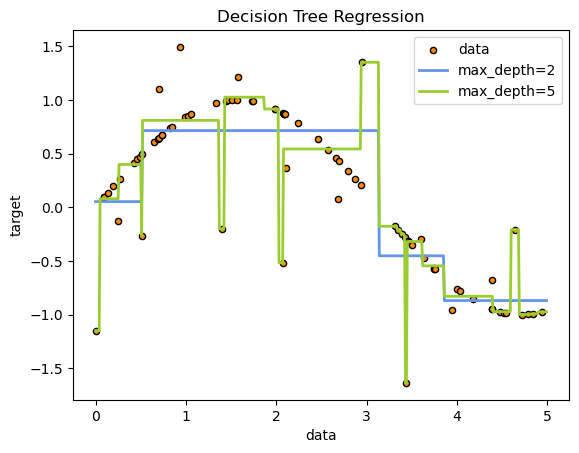

In [7]:
# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

# Plot the results
plt.figure()
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=2", linewidth=2)
plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

Let's take a look at how the first decision tree works.

[Text(0.5, 0.8333333333333334, 'x[0] <= 3.133\nsquared_error = 0.547\nsamples = 80\nvalue = 0.122'),
 Text(0.25, 0.5, 'x[0] <= 0.514\nsquared_error = 0.231\nsamples = 51\nvalue = 0.571'),
 Text(0.125, 0.16666666666666666, 'squared_error = 0.192\nsamples = 11\nvalue = 0.052'),
 Text(0.375, 0.16666666666666666, 'squared_error = 0.148\nsamples = 40\nvalue = 0.714'),
 Text(0.75, 0.5, 'x[0] <= 3.85\nsquared_error = 0.124\nsamples = 29\nvalue = -0.667'),
 Text(0.625, 0.16666666666666666, 'squared_error = 0.124\nsamples = 14\nvalue = -0.452'),
 Text(0.875, 0.16666666666666666, 'squared_error = 0.041\nsamples = 15\nvalue = -0.869')]

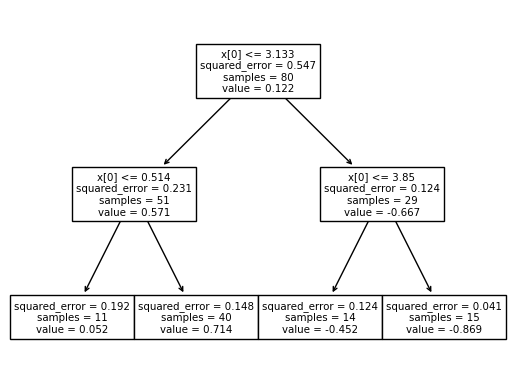

In [8]:
from sklearn.tree import plot_tree
plot_tree(regr_1)

## Random Forests 

### Introduction
Random Forest is an ensemble of decision trees. Each tree is trained **independently** on a **random subset** of the training data, known as bootstrap samples. This process is called bagging (Bootstrap Aggregating). Additionally, Random Forest introduces randomness by considering only a random subset of features at each split of the tree. This helps in reducing correlation among the trees and improving the diversity of the ensemble.

Once all the trees are trained, predictions are made by aggregating the predictions of individual trees. For **classification** tasks, the mode (most frequent class) of the predictions is taken as the final prediction, while for **regression** tasks, the average of the predictions is computed.

### An example of Random Forest

In [9]:
import pandas as pd
import numpy as np

# Read in data and display first 5 rows
features = pd.read_csv('_data/temps.csv')
features.head(5)

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61
2,2016,1,3,Sun,45,44,45.8,41,43,46,47,56
3,2016,1,4,Mon,44,41,45.9,40,44,48,46,53
4,2016,1,5,Tues,41,40,46.0,44,46,46,46,41


* **Temp_2** : Maximum temperature on 2 days prior to today. 
* **Temp_1**: Maximum temperature on yesterday. 
* **Average**: Historical temperature average 
* **Actual**: Actual measure temperature on today. 
* **Forecast_NOAA**: Temperature values forecasted by NOAA
* **Friend**: Forecasted by Friend (Randomly selected number within plus-minus 20 of Average temperature)

In [10]:
print('The shape of our features is:', features.shape)

The shape of our features is: (348, 12)


In [11]:
# Descriptive statistics for each column
features.describe()


,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
count,348.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2016.0,6.477011,15.514368,62.652299,62.701149,59.760632,62.543103,57.238506,62.373563,59.772989,60.034483
std,0.0,3.498380,8.772982,12.165398,12.120542,10.527306,11.794146,10.605746,10.549381,10.705256,15.626179
min,2016.0,1.000000,1.000000,35.000000,35.000000,45.100000,35.000000,41.000000,46.000000,44.000000,28.000000
25%,2016.0,3.000000,8.000000,54.000000,54.000000,49.975000,54.000000,48.000000,53.000000,50.000000,47.750000
50%,2016.0,6.000000,15.000000,62.500000,62.500000,58.200000,62.500000,56.000000,61.000000,58.000000,60.000000
75%,2016.0,10.000000,23.000000,71.000000,71.000000,69.025000,71.000000,66.000000,72.000000,69.000000,71.000000
max,2016.0,12.000000,31.000000,117.000000,117.000000,77.400000,92.000000,77.000000,82.000000,79.000000,95.000000


In [12]:
# Use datetime for dealing with dates
features['date'] = pd.to_datetime(features[['year', 'month', 'day']])
features.set_index('date', inplace=True)

**Quality Check**

Identifying anomalous patterns by visually observing their plots


array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

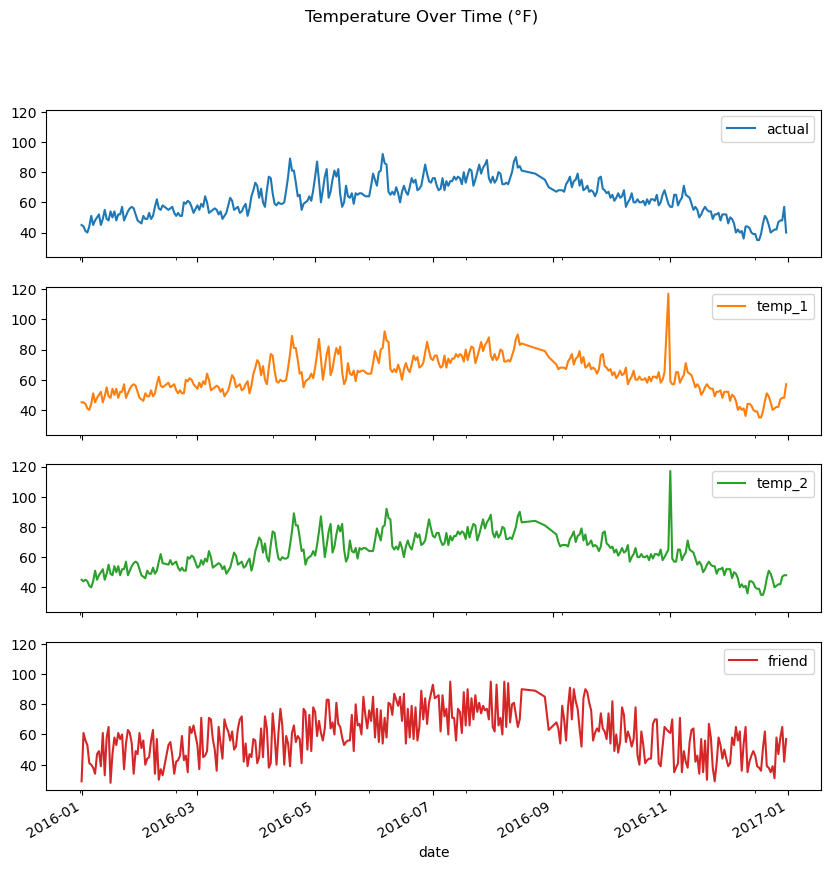

In [13]:
features[['actual', 'temp_1', 'temp_2', 'friend']].plot(subplots=True, sharey=True, figsize=(10, 10), title='Temperature Over Time (°F)')

**Data Preparation**

##### 1. One-Hot Encoding



One-hot encoding is used to convert categorical values to numerical values. If the data was labeled from 1 to 7 for the days of the week, it would artificially assign greater importance to Sunday.

In [14]:
# One-hot encode the data using pandas get_dummies
features = pd.get_dummies(features)
# Display the first 5 rows of the last 12 columns
features.iloc[:,5:].head(5)

,average,actual,forecast_noaa,forecast_acc,forecast_under,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
date,,,,,,,,,,,,,
2016-01-01,45.6,45,43,50,44,29,True,False,False,False,False,False,False
2016-01-02,45.7,44,41,50,44,61,False,False,True,False,False,False,False
2016-01-03,45.8,41,43,46,47,56,False,False,False,True,False,False,False
2016-01-04,45.9,40,44,48,46,53,False,True,False,False,False,False,False
2016-01-05,46.0,44,46,46,46,41,False,False,False,False,False,True,False


2. Separating Features and Labels

labels in this case are the actual values of temperature

In [15]:
# Use numpy to convert to arrays
# import numpy as np
# Labels are the values we want to predict
labels = features['actual']

# Remove the labels from the features
# axis 1 refers to the columns
features = features.drop('actual', axis = 1)


3. Splitting the data randomly into Test and Training sets

random_state = 42 ensure the similarity of the split in each iteration

In [16]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

4. Setting up the model baseline

In [17]:
# The baseline predictions are the historical averages
baseline_preds = test_features['average']
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(baseline_errors.mean(), 2))

Average baseline error:  5.06


5. Initializing a random forest regression model

In [18]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels)

RandomForestRegressor(n_estimators=1000, random_state=42)

6. Assessing the performance of a model 

In [19]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(errors.mean(), 2), 'degrees.')

Mean Absolute Error: 3.87 degrees.


In [20]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - mape.mean()
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 93.93 %.


7. Computing the Feature Importances

In [21]:
rf.feature_importances_

array([0.        , 0.01032971, 0.02111933, 0.02099328, 0.65555327,
       0.15032983, 0.04538229, 0.03485937, 0.02319048, 0.02068467,
       0.00352492, 0.00258813, 0.0036125 , 0.00228907, 0.00126645,
       0.00230266, 0.00197403])

In [22]:
train_features.columns

Index(['year', 'month', 'day', 'temp_2', 'temp_1', 'average', 'forecast_noaa',
       'forecast_acc', 'forecast_under', 'friend', 'week_Fri', 'week_Mon',
       'week_Sat', 'week_Sun', 'week_Thurs', 'week_Tues', 'week_Wed'],
      dtype='object')

In [23]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = pd.Series(rf.feature_importances_, index = train_features.columns)
# Sort the feature importances by most important first
feature_importances.sort_values(ascending=False, inplace=True)
# feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
# [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];
feature_importances

temp_1            0.655553
average           0.150330
forecast_noaa     0.045382
forecast_acc      0.034859
forecast_under    0.023190
day               0.021119
temp_2            0.020993
friend            0.020685
month             0.010330
week_Sat          0.003613
week_Fri          0.003525
week_Mon          0.002588
week_Tues         0.002303
week_Sun          0.002289
week_Wed          0.001974
week_Thurs        0.001266
year              0.000000
dtype: float64

In [24]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)
# Extract the two most important features
train_important = train_features[['temp_1', 'average']]
test_important = test_features[['temp_1', 'average']]
# Train the random forest
rf_most_important.fit(train_important, train_labels)

# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - test_labels)
# Display the performance metrics
print('Mean Absolute Error:', round(errors.mean(), 2), 'degrees.')
mape = 100 * (errors / test_labels)
accuracy = 100 - mape.mean()
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 3.92 degrees.
Accuracy: 93.76 %.


<Axes: >

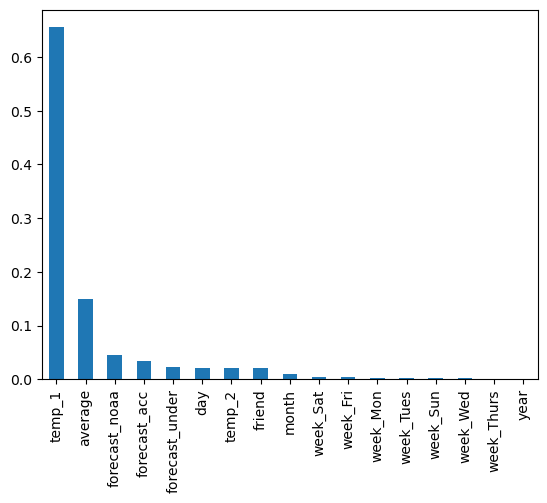

In [25]:
feature_importances.plot.bar()


<Axes: xlabel='date'>

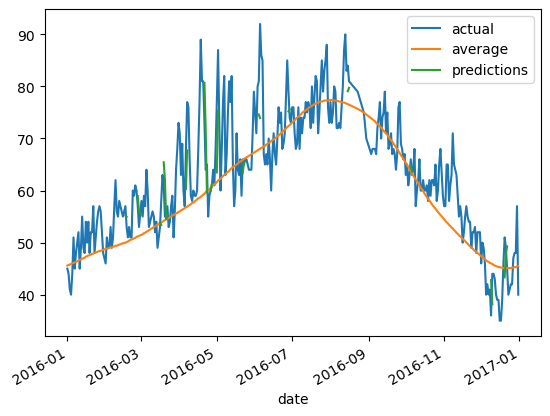

In [26]:
# Stack the true value, the average and the predictions together and plot
pd.concat([labels, features['average'], pd.Series(predictions, index=test_important.index, name='predictions')], axis=1).plot()

**Summary on Random Forests:**

- Easy-to-understand hyperparameters.
- Overfitting not a problem with enough trees.
- More trees needed for better accuracy.
- Can get slower with more trees.


# Gaussian Process Regression

Gaussian process regression (GPR) is a non-parametric regression technique that can be used to model complex patterns in the data. It is based on the assumption that the data is generated from a Gaussian process, which is a collection of random variables, any finite number of which have a joint Gaussian distribution.

GPR has some nice properties:
 - It provides uncertainty estimates for the predictions.
 - It can be used for both regression and classification.
 - It is computationally efficient for small to medium-sized datasets.

Recent work composing 'nested' GPs, referred to as 'Deep GPs' are also useful to know about and can offer a powerful alternative to NN's, particularly in the low-data regime.

Thanks to the examples from https://peterroelants.github.io/posts/gaussian-process-tutorial/ explaining GP basics.

Other resources used in this lesson include:
 - https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html
 - https://nbviewer.org/github/adamian/adamian.github.io/blob/master/talks/Brown2016.ipynb
 - https://domino.ai/blog/fitting-gaussian-process-models-python

In [27]:
import scipy
from scipy.stats import binned_statistic_2d
from scipy.stats import multivariate_normal

np.random.seed(42)


# Intuition from Brownian motion

Before we start talking about gaussian process regression, let's think about a simple stochastic process. Stochastic processes change randomly over time. A classic example of this is a random walk. We can generalize this to a continuous random walk, or Brownian motion (Wiener process) where fluid particles move randomly due to collisions with other particles. 

We can think of a particle starting at 0 and at intervals $\Delta t$ moving some distance $\Delta d$ from its previous position. Where  distance increments are drawn from a normal distribution $\Delta d=\mathcal{N}(0,\Delta t)$. Simulating a particle trajectory as follows.

In [28]:
# 1D simulation of the Brownian motion process
total_time = 1
nb_steps = 1000
delta_t = total_time / nb_steps
nb_processes = 5  # Simulate 5 different motions

mean = 0.  # Mean of each movement
stdev = np.sqrt(delta_t)  # Standard deviation of each movement

# Simulate the brownian motions in a 1D space by cumulatively
#  making a new movement delta_d
distances = np.cumsum(
    # Move randomly from current location to N(0, delta_t)
    np.random.normal(
        mean, stdev, (nb_processes, nb_steps)),
    axis=1)

[Text(0.5, 0, 'Time'), Text(0, 0.5, 'Position')]

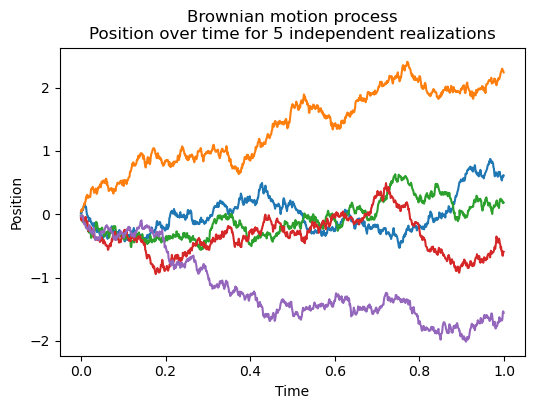

In [29]:
# Make the plots
plt.figure(figsize=(6, 4))
t = np.arange(0, total_time, delta_t)
for i in range(nb_processes):
    plt.plot(t, distances[i,:])

plt.title(f"Brownian motion process\nPosition over time for {nb_processes} independent realizations")
plt.setp(plt.gca(), xlabel='Time', ylabel='Position')


In this example we have created 5 different realizations of a random walk. Each realization can be thought of a function giving distance as a function of time ($f(t)=d$). 

Stochastic processes can be thought of as a random distribution over functions. Gaussian processes are a stochastic process.

# Gaussian process

Gaussian processes are defined by a mean and covariance between points in the domain:

$f(x)=\mathcal{GP}(m(x),k(x,x'))$

where $m(x)$ is the mean and $k(x,x')$ is a positive definite covariance matrix between all possible pairs in the domain $(x,x')$. 

For some finite subset of points this can be represented as a multivariate normal distribution:

$f(X)=\mathcal{N}(\mu,\Sigma)$

where $\Sigma$ is a covariance matrix linking some finite number of normal distributions. 

Unlike the multivariate normal (MVN), the GP doesn't have the limitation of a finite number of normals and its mean and covariance are defined by functions. Another way to relate these concepts is to think of a GP as an infinite dimensional MVN. Let's glance at a MVN to remind ourselves of what these look like.

In [30]:
def gen_Gaussian_samples(mu, sigma, N=200):
    """
    Generate N samples from a multivariate Gaussian with mean mu and covariance sigma
    """
    samples = np.random.multivariate_normal(mean=mu, cov=sigma,size=N)
    return samples.copy()

def plt_gauss_contours(mu,sigma):
    x, y = np.mgrid[-2:2:.01, -2:2:.01]
    pos = np.dstack((x, y))
    rv = multivariate_normal(mu, sigma)
    plt.contourf(x, y, rv.pdf(pos),cmap='binary')
    plt.xlim(-2,2); plt.ylim(-2,2)

We can take a first look at a pair of uncorrelated gaussians. Red dots are individual realizations drawn from the MVN. Note that this is equivalent to the Brownian motion example above.

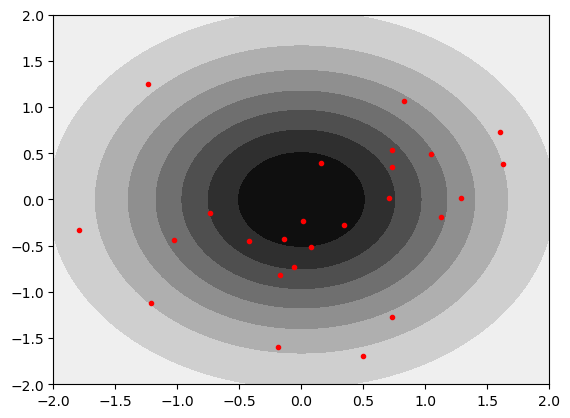

In [31]:
mu = np.array([0,0])  # Mean of the 2D Gaussian
COV=0.0
sigma = np.array([[1, COV], [COV, 1]]); # covariance of the Gaussian
samples = gen_Gaussian_samples(mu,sigma,N=30) 
plt_gauss_contours(mu,sigma)
plt.plot(samples[:,0],samples[:,1],'.r')

Let's try making the gaussians correlated by changing the off diagonals of the covariance matrix.

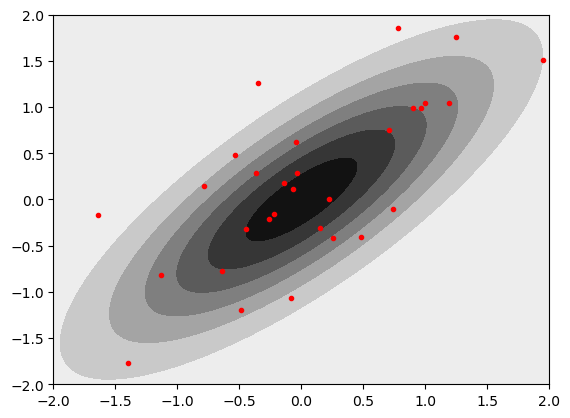

In [32]:
mu = np.array([0,0])  # Mean of the 2D Gaussian
COV=0.8
sigma = np.array([[1, COV], [COV, 1]]); # covariance of the Gaussian
samples = gen_Gaussian_samples(mu,sigma,N=30) 
plt_gauss_contours(mu,sigma)
plt.plot(samples[:,0],samples[:,1],'.r')


We can think about conditioning and marginalizing the multivariate normal. Visually, this is drawing a line through the distribution or summing to one axis. To illustrate this quickly and dirtily (but hopefully transparently) we can just generate a lot of samples, bin them, and plot them. 

<Figure size 600x600 with 0 Axes>

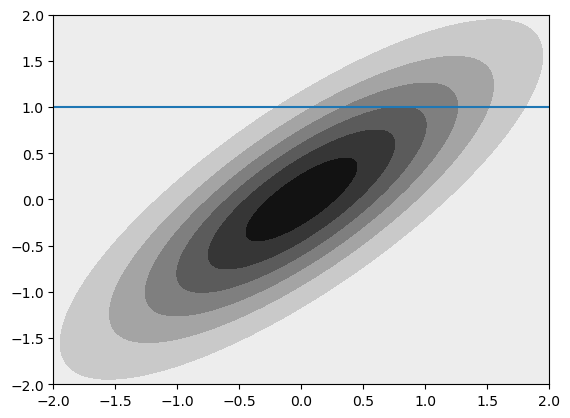

<Figure size 600x600 with 0 Axes>

In [33]:
mu = np.array([0,0])  # Mean of the 2D Gaussian
COV=0.8
sigma = np.array([[1, COV], [COV, 1]]); # covariance of the Gaussian
plt_gauss_contours(mu,sigma)
plt.axhline(1)
samples = gen_Gaussian_samples(mu,sigma,N=1000000) 
plt.figure(figsize=(6,6))

Text(0.5, 1.0, 'Conditional')

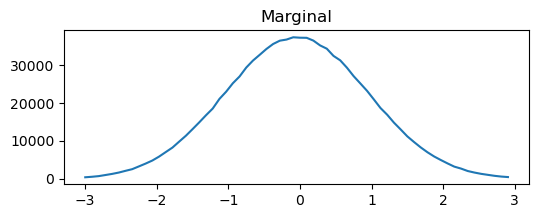

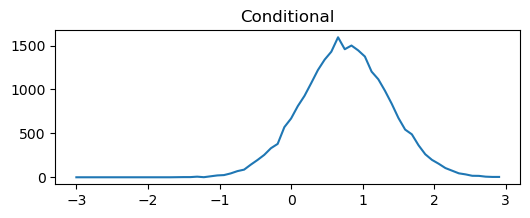

In [34]:
binned=binned_statistic_2d(samples[:,0],samples[:,1],samples[:,1],statistic='count',bins=[np.linspace(-3,3,60),np.linspace(-3,3,65)])
plt.figure(figsize=(6,2))
plt.plot(binned[2][0:-1],sum(binned[0],1))
plt.title('Marginal')
plt.figure(figsize=(6,2))
plt.plot(binned[2][0:-1],binned[0][np.argmin(abs(binned[1]-1))])
plt.title('Conditional')

From this simplified example we can begin to see the utility of the covariance matrix in setting the type of realization we will get from our GP. This example just has two points (so we can plot it), but we can imagine extending this to an infinite dimensional MVN (GP) by having a function that defines the covariance rather than a discrete matrix. In the example above you can play around with the conditional and marginal distributions by altering the covariance.

# Kernel function

The function we use to set our covariances act as a prior on joint variability of the GP random variables. The covariance is represented by a kernel $k(x_a,x_b)$. An easy example to conceptualize how the kernel acts as a prior is to consider the simplest possible case where $k(x_a,x_b)=0$. This will have a much different behavior than any other kernel.  

Here, we can consider the exponentiated quadratic or radial basis function (RBF) kernel to get an idea of how these work:
$k(x_a,x_b)=exp(\frac{-1}{\sigma^2} ||x_a-x_b||^2)$

One thing you will notice is that we have introduced a tunable parameter in the kernel: $\sigma$. This sets the fall off in covariance between points. Many other kernels are possible and have similar tunable parameters. We will fit these parameters later when we talk about regression. For now we can just look at the RBF. For these notes we can just manually define these, but you will nearly always use a package that does all of this for you.

In [35]:
def exponentiated_quadratic(xa, xb,sigma=1):
    """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    sq_norm = -1/(2*sigma**2) * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm)

<center><img src="_images/GP_covariance.png" alt="GP Covariance" width="600"/></center>

The kernel gives a covariance for all possible combinations of $x$. We can vary the covariance behavior by altering the code above. As you can see, the covariance between points goes to 1 when they are right on top of each other and then tails off. You can alter that tailing off by changing the $\sigma$ in the kernel. 

# Fitting with Gaussian Process Regression

Ok great- we can pull priors from an infinite dimension MVN. We can set the way that our MVN works with kernels. Obviously we want to do the thing it says on the can: regression. Doing this is conceptually easy. We throw out all of our infinte priors that don't intersect with our fit data.  The GP is our prior based on our choice of kernels and we are going to build a posterior that agrees with some observations (observations of $y$ at some selection of $X$). We can then use that posterior function to predict $y$ at some new set of $X$

Let's work through the math (briefly). Let's say we have $n_1$ data points we have observed that we will be training our fit with $(X_1,y_1)$. We want to get predictions at some new set of $n_2$ points ($y_2=f(X_2)$). This is our posterior distribution $p(y_2|y_1,X_1,X_2)$. Keep in mind that $y_1$ and $y_2$ are both coming from the same MVN.

$\begin{bmatrix} y_1 \\ y_2 \end{bmatrix} \sim \mathcal{N}(\begin{bmatrix} \mu_1 \\ \mu_2 \end{bmatrix},\begin{bmatrix} \Sigma_{11}, \Sigma_{12} \\ \Sigma_{21}, \Sigma_{22} \end{bmatrix})$

So we are drawing values from some MVN that has been split into two chunks (1 and 2) and we can now think about getting our conditional distribution based on the data we have in 1.

$p(y_2|y_1,X_1,X_2)=\mathcal{N}(\mu_{2|1},\Sigma_{2|1})$

Somewhat surprisingly (to me at least!), there is a closed-form solution for the conditional mean and covariance matrix which is given in a variety of GP textbooks (e.g. Rasmussen and Williams) and they are included in the notes.

This means we can make predictions of the mean and the variance of our points at $X_2$ using, respectively, $\mu_{2|1}$ and the diagonal of $\Sigma_{2|1}$. Note that our prediction of $\mu_2|1$ is based on weighting our observations $y_1$ by our kernel. 

While you will use some package like `gpflow`, `sklearn`, etc. to do this in practice, we can use scipy to do the linear algebra explicitly.

In [36]:
def GP(X1, y1, X2, kernel_func,sigma):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1), 
    and the prior kernel function.
    """
    # Kernel of the observations
    Σ11 = kernel_func(X1, X1,sigma)
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2,sigma)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2,sigma)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

In [37]:
f_sin = lambda x: (np.sin(x)).flatten()
SIGMA=np.sqrt(1)
n1 = 8  # Number of points to condition on (training points)
n2 = 75  # Number of points in posterior (test points)
ny = 5  # Number of functions that will be sampled from the posterior
domain = (-6, 6)

# Sample observations (X1, y1) on the function
X1 = np.random.uniform(domain[0]+2, domain[1]-2, size=(n1, 1))
y1 = f_sin(X1)
# Predict points at uniform spacing to capture function
X2 = np.linspace(domain[0], domain[1], n2).reshape(-1, 1)
# Compute posterior mean and covariance
μ2, Σ2 = GP(X1, y1, X2, exponentiated_quadratic,SIGMA)
# Compute the standard deviation at the test points to be plotted
σ2 = np.sqrt(np.diag(Σ2))

# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=μ2, cov=Σ2, size=ny)

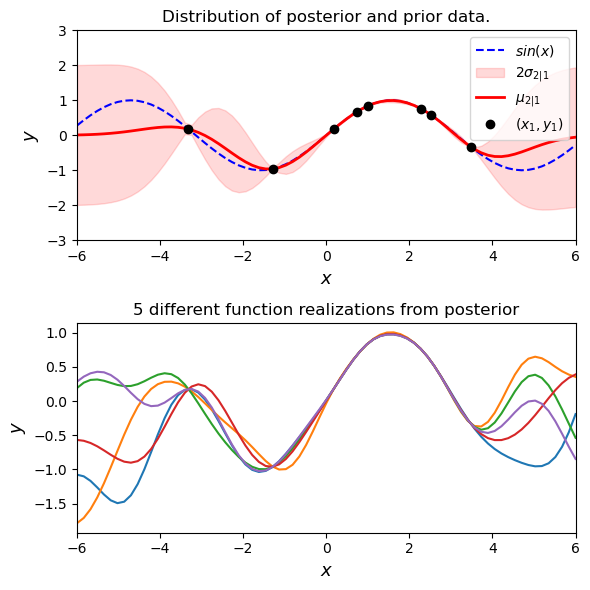

In [38]:
# Plot the postior distribution and some samples
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(6, 6))
# Plot the distribution of the function (mean, covariance)
ax1.plot(X2, f_sin(X2), 'b--', label='$sin(x)$')
ax1.fill_between(X2.flat, μ2-2*σ2, μ2+2*σ2, color='red', 
                 alpha=0.15, label='$2 \sigma_{2|1}$')
ax1.plot(X2, μ2, 'r-', lw=2, label='$\mu_{2|1}$')
ax1.plot(X1, y1, 'ko', linewidth=2, label='$(x_1, y_1)$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('Distribution of posterior and prior data.')
ax1.axis([domain[0], domain[1], -3, 3])
ax1.legend()
# Plot some samples from this function
ax2.plot(X2, y2.T, '-')
ax2.set_xlabel('$x$', fontsize=13)
ax2.set_ylabel('$y$', fontsize=13)
ax2.set_title('5 different function realizations from posterior')
ax1.axis([domain[0], domain[1], -3, 3])
ax2.set_xlim([-6, 6])
plt.tight_layout()
plt.show()
#

One again note that we have just set the parameters in the kernel. You can change the $\sigma$ in the kernel by change the code above to explore different potential kernel configurations.

GRP carries an estimate of its own fitting uncertainty with it. This is shown as red shading in the plot above. Since these are just MVNs the calculation of the confidence interval is just 1.96 times the standard deviation. We plot a few different realizations that fit through our points in the plot below

# Imperfect (noisy) observations

You will notice that we have forced our infinite possible priors to fit through the observations perfectly. Realistically, observations will have some noise to them. If we model our observation noise as a white noise 

$f(X_1)=y_1+\epsilon$

this can be added to the diagonal of our covariance

$\Sigma_{11}=k(X_1,X_1) +\sigma_{\epsilon}^2 I$

updating the code to handle some noise in the training data

In [39]:
def GP_noise(X1, y1, X2, kernel_func, sigma_noise):

    # Kernel of the noisy observations
    Σ11 = kernel_func(X1, X1) + ((sigma_noise ** 2) * np.eye(n1))
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

In [40]:
# Compute the posterior mean and covariance

sigma_noise = 0.3  # The standard deviation of the noise

# Add noise kernel to the samples we sampled previously
y1 = y1 + ((sigma_noise ** 2) * np.random.randn(n1))

# Compute posterior mean and covariance
μ2, Σ2 = GP_noise(X1, y1, X2, exponentiated_quadratic, sigma_noise)
# Compute the standard deviation at the test points to be plotted
σ2 = np.sqrt(np.diag(Σ2))

# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=μ2, cov=Σ2, size=ny)

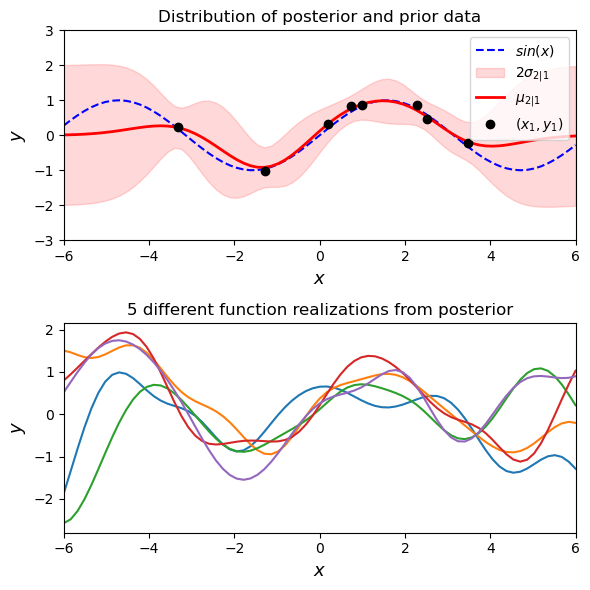

In [41]:
# Plot the postior distribution and some samples
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(6, 6))
# Plot the distribution of the function (mean, covariance)
ax1.plot(X2, f_sin(X2), 'b--', label='$sin(x)$')
ax1.fill_between(X2.flat, μ2-2*σ2, μ2+2*σ2, color='red', 
                 alpha=0.15, label='$2\sigma_{2|1}$')
ax1.plot(X2, μ2, 'r-', lw=2, label='$\mu_{2|1}$')
ax1.plot(X1, y1, 'ko', linewidth=2, label='$(x_1, y_1)$')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('Distribution of posterior and prior data')
ax1.axis([domain[0], domain[1], -3, 3])
ax1.legend()
# Plot some samples from this function
ax2.plot(X2, y2.T, '-')
ax2.set_xlabel('$x$', fontsize=13)
ax2.set_ylabel('$y$', fontsize=13)
ax2.set_title('5 different function realizations from posterior')
ax1.axis([domain[0], domain[1], -3, 3])
ax2.set_xlim([-6, 6])
plt.tight_layout()
plt.show()
#

Now we don't have to fit all of our posterior realizations perfectly through the data points because we have some noise in our observations. You can change the amount of noise that is being allowed in the observations above. The noise can be thought of as a hyperparameter that can be fit to the data.

One way of viewing this is that we have added an additional kernel to the RBF kernel we have been using. In fact, you can add (and multiply) kernels together to fit complex functions. 

This is just a taste of using Gaussian processes. Like many things in data analysis, there are lots of packages we can use to simplify this process dramatically, and extend to much larger datasets using (very good) approximations. We can use lots of different kernels- one useful resource presenting many commonly used kernels is David Duvenaud's kernel cookbook (https://www.cs.toronto.edu/~duvenaud/cookbook/).

# Homework

Work through the Mauna Loa Observatory example in the notebook (which comes from https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html)
